In [1]:
import timm
import torch
import wandb
import fastai
import dill
import numpy as np
from fastai.callback.wandb import *
from fastai.vision.all import *
from fastai.vision.core import *
from fastai.text.core import RegexLabeller
from fastai.vision.utils import get_image_files
from fastai.data.block import DataBlock
from fastai.data.core import *
from fastai.tabular.all import *
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from huggingface_hub import notebook_login, push_to_hub_fastai, from_pretrained_fastai
# os.environ['WANDB_WATCH'] = 'false'

In [2]:
config = SimpleNamespace(
    batch_size=64,  #16, #256,
    epochs=5,
    # learning_rate=2e-3,
    img_size=224,
    seed=42,
    pretrained=True,
    top_k_losses=5,
    model_name="maxvit_rmlp_small_rw_224.sw_in1k",# try with maxvit_nano_rw_256.sw_in1k # regnetx_040 coatnet_bn_0_rw_224.sw_in1k
    wandb_project="Beetle_classifier", 
    wandb_group="ambrosia_symbiosis",
    job_type="training"
    )

In [3]:
def get_images(dataset_path, batch_size, img_size, seed):
    "The beetles dataset"
    files = get_image_files(path=dataset_path, recurse=True, folders=('train','valid'))
    dblock = DataBlock(blocks = (ImageBlock, CategoryBlock),
                       get_items = get_image_files,
                       splitter = GrandparentSplitter(train_name='train', valid_name='valid'),
                       get_y = parent_label,
                       item_tfms = Resize(img_size, ResizeMethod.Pad, pad_mode='zeros'))
    dls = dblock.dataloaders(dataset_path, bs = batch_size)
    return dls

def train(config, dataset_path):
    "Train the model using the supplied config"
    dls = get_images(dataset_path=dataset_path, batch_size=config.batch_size, img_size=config.img_size, seed=config.seed)
    # wandb.init(project=config.wandb_project, group=config.wandb_group, job_type=config.job_type, config=config) # it is a good idea to keep these functions out of the training function due to some exporting issues
    cbs = [MixedPrecision(), ShowGraphCallback(), SaveModelCallback(), WandbCallback(log='gradients')] # (all, parameters, gradients or None) parameters and all does nto work currently wandb needs to be updated
    learn = vision_learner(dls, 
                           config.model_name, 
                           loss_func=LabelSmoothingCrossEntropyFlat(),
                           metrics=[error_rate, 
                                    accuracy, 
                                    top_k_accuracy], 
                           cbs=cbs, 
                           pretrained=config.pretrained)
    learn.fine_tune(config.epochs)
    interp = ClassificationInterpretation.from_learner(learn)
    interp.plot_confusion_matrix()
    interp.plot_top_losses(config.top_k_losses, nrows=config.top_k_losses)
    # wandb.finish() # it is a good idea to keep these functions out of the training function due to some exporting issues
    return learn

# this function only describes how much a singular value in al ist stands out.
# if all values in the lsit are high or low this is 1
# the smaller the proportiopn of number of disimilar vlaues are to other more similar values the lower this number
# the larger the gap between the dissimilar numbers and the simialr number the smaller this number
# only able to interpret probabilities or values between 0 and 1
# this function outputs an estimate an inverse of the classification confidence based on the probabilities of all the classes.
# the wedge threshold splits the data on a threshold with a magnitude of a positive int to force a ledge/peak in the data
def unkown_prob_calc(probs, wedge_threshold, wedge_magnitude=1, wedge=True):
    if wedge:
        probs = np.where(probs<=wedge_threshold , probs**(2*wedge_magnitude), probs)
        probs = np.where(probs>=wedge_threshold , probs**(1/(2*wedge_magnitude)), probs)
    diff_matrix = np.abs(probs[:, np.newaxis] - probs)
    diff_matrix_sum = np.sum(diff_matrix)
    probs_sum = np.sum(probs)
    class_val = (diff_matrix_sum/probs_sum)
    max_class_val = ((len(probs)-1)*2)
    kown_prob = class_val/max_class_val
    unknown_prob = 1-kown_prob
    return(unknown_prob)

epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


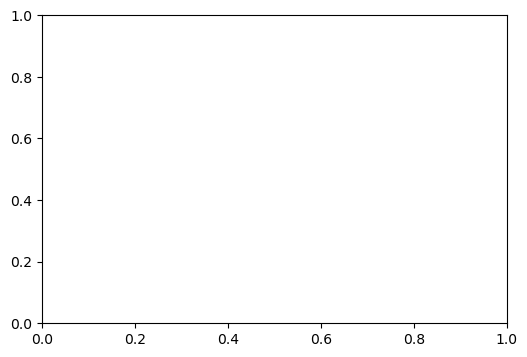

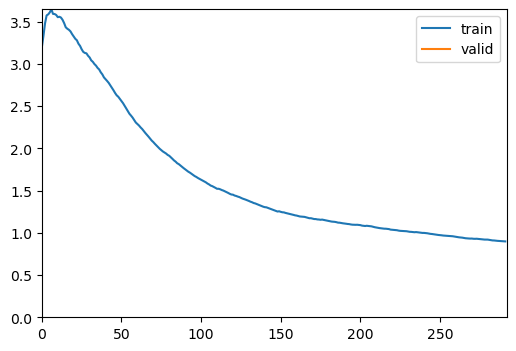

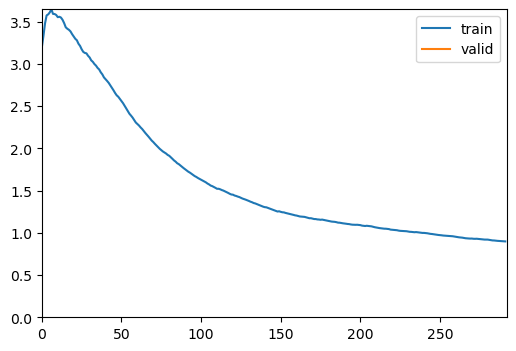

epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.898578,0.692565,0.032812,0.967188,0.999830,05:04


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


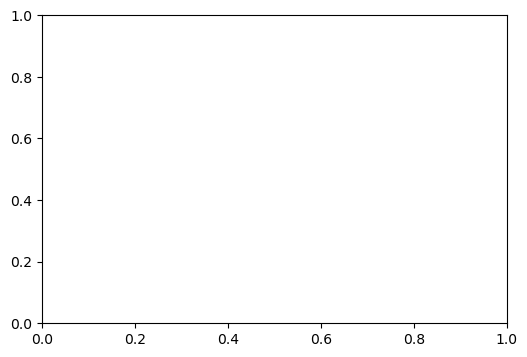

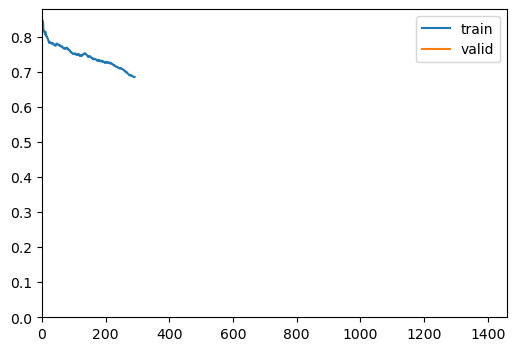

epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18


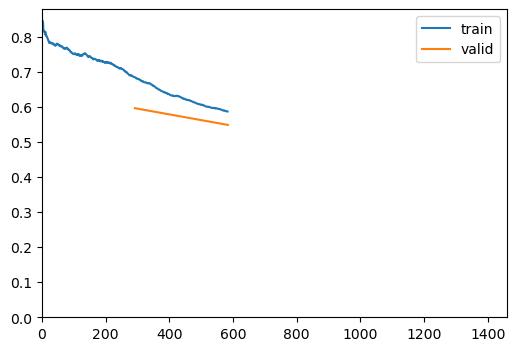

epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01


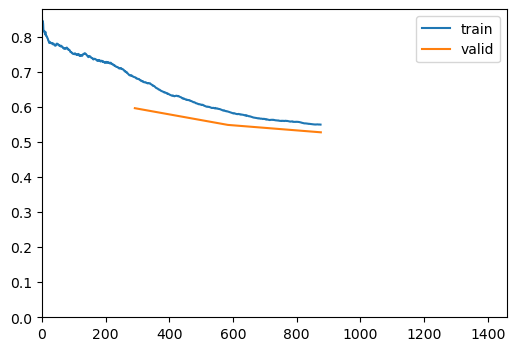

epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08


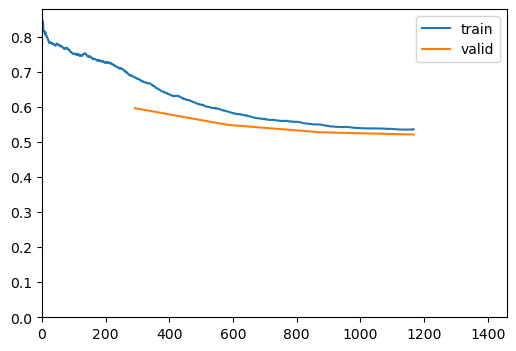

epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05


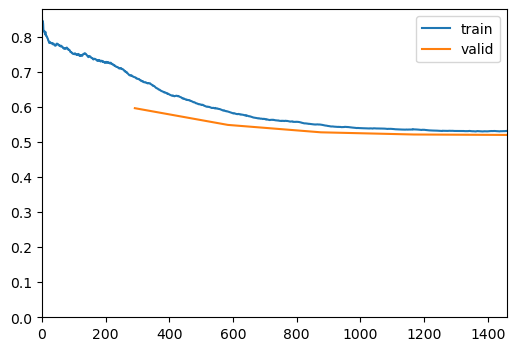

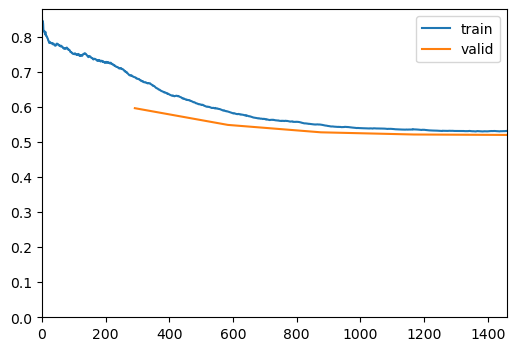

epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.685406,0.596605,0.008160,0.991840,1.000000,02:18
1,0.587222,0.548907,0.002210,0.997790,1.000000,02:01
2,0.549782,0.527760,0.000340,0.999660,1.000000,02:08
3,0.536434,0.521522,0.000340,0.999660,1.000000,02:05
4,0.531665,0.520269,0.000510,0.999490,1.000000,02:42


In [4]:
# Train Model
wandb.init(project=config.wandb_project, group=config.wandb_group, job_type=config.job_type, config=config)
learn = train(config=config, dataset_path=r"/blue/hulcr/gmarais/Beetle_data/selected_images/train_data")
wandb.finish()